In [15]:
# 8 PUFs, 256 ROs, 5 inv, wait_ns 10000, 
from pynq import Overlay, allocate
import matplotlib.pyplot as plt
import pynq_composable
import numpy as np
import math
import time
from scipy.spatial.distance import hamming
from scipy.stats import norm 
import statistics
from tqdm.notebook import tqdm 

ol = Overlay("ro_02/ro_02.bit") 

PUF = ol.ROs
#PUF.c_dict

n_PUF = 15
n_ROs = 256
wait_ns = 10000
clk_period_ns = 10

PUF_names = ["" for x in range(n_PUF)]
PUF_init = [0 for x in range(n_PUF)]
for i in range(n_PUF):
    PUF_names[i] = "ROPUF_"+ str(i)  

current_PUF = -1   
    
def switch_PUF(i):
    global current_PUF
    global PUF_init
    
    if current_PUF == i:
        return
    
    PUF.compose([PUF.ps_in, getattr(PUF,PUF_names[i]), PUF.ps_out])
    current_PUF = i
    
    if PUF_init[i] == 1:
        return
    
    PUF_init[i] = 1
    #Flush initial queue
    dma_recv.transfer(output_buffer)
    dma_recv.wait()      

In [12]:
PUF.c_dict

{'ROPUF_4': {'si': [0],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [0]},
 'ROPUF_3': {'si': [1],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [2]},
 'ROPUF_2': {'si': [2],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [3]},
 'ROPUF_0': {'si': [4],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [4]},
 'ROPUF_1': {'si': [5],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [5]},
 'ROPUF_5': {'si': [6],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [7]},
 'ROPUF_6': {'mi': [6],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'si': [7]},
 'ROPUF_7': {'si': [8],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [8]},
 'ROPUF_9': {'si': [9],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [9]},
 'ROPUF_10': {'si': [10],
  'dfx': False,
  'loaded': True,
  'modtype': 'ROPUF',
  'mi': [10]},
 'ROPUF_11': {'si': [11],
  'dfx': False,
  'loaded': Tru

In [16]:
buffer_size = 2
input_buffer = allocate(shape=(1,), dtype=np.int32)
output_buffer = allocate(shape=(buffer_size,), dtype=np.int32)

dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel

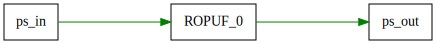

In [14]:
switch_PUF(0)
PUF.graph

In [5]:
input_buffer[:] = [int("0000", base = 16)]
for j in range(math.floor(buffer_size/2)):
    index_l = j*2;
    index_r = index_l + 2;
    dma_send.transfer(input_buffer)
    dma_send.wait()
    dma_recv.transfer(output_buffer[index_l:index_r])
    dma_recv.wait()
print(output_buffer[::2]) #even index
print(output_buffer[1::2]) #odd index

[2394]
[2394]


  0%|          | 0/15 [00:00<?, ?it/s]

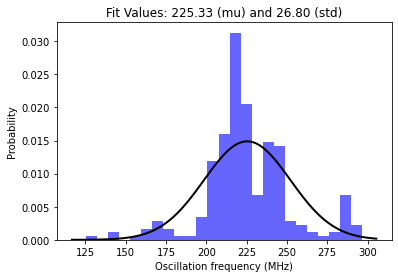

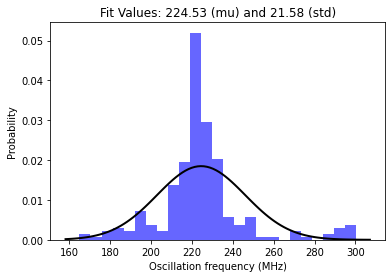

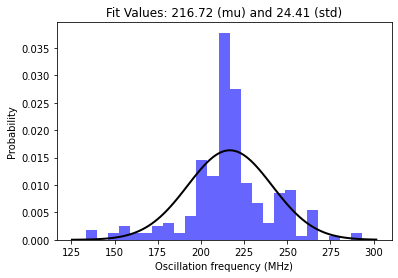

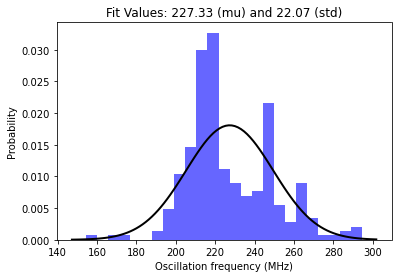

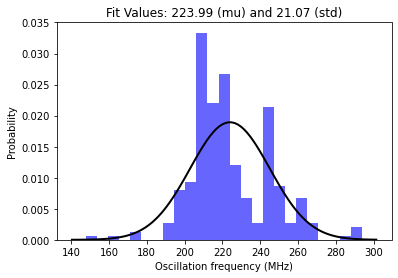

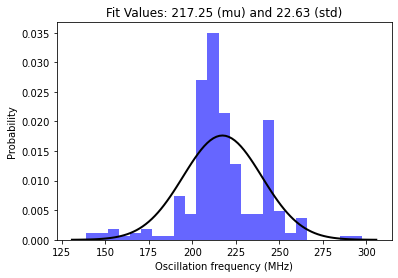

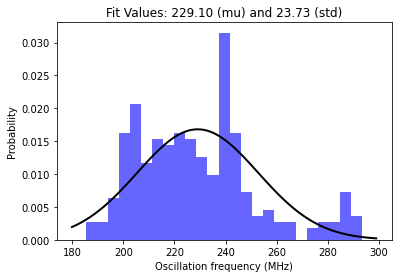

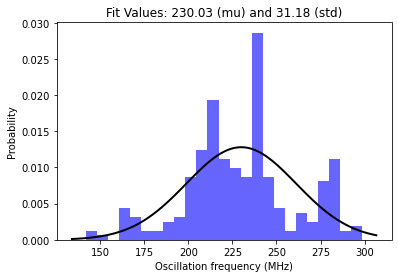

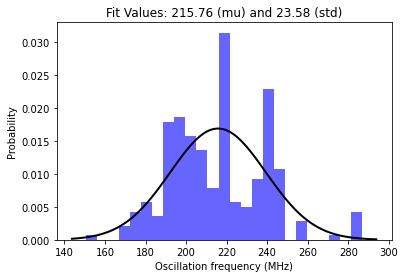

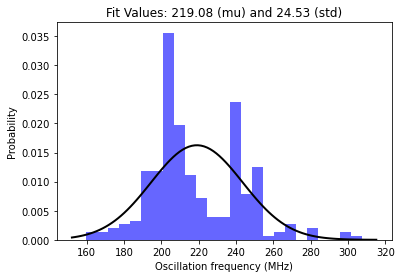

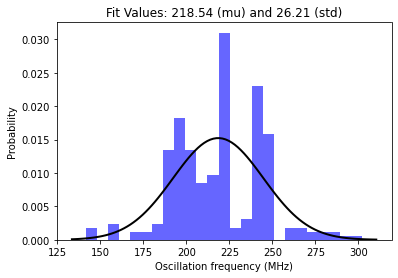

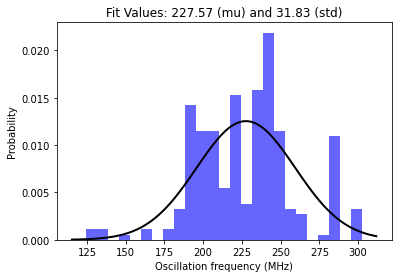

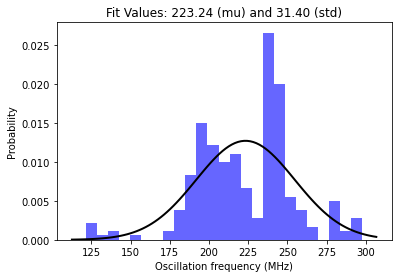

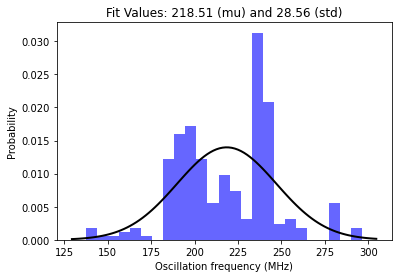

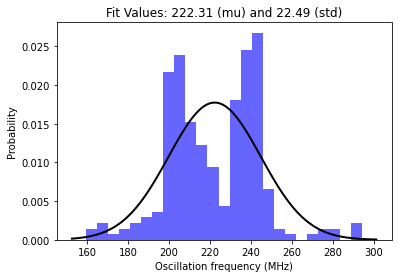

In [6]:
# pdf of the oscillation frequency 
for j in tqdm(range(n_PUF)):
    switch_PUF(j)
    frequency = np.zeros(shape=(2,n_ROs)) #data1[y][x] 
    challenge = 0
    for i in range(n_ROs):
        input_buffer[:] = challenge
        challenge = challenge + n_ROs + 1;
        for j in range(math.floor(buffer_size/2)):
            index_l = j*2;
            index_r = index_l + 2;
            dma_send.transfer(input_buffer)
            dma_send.wait()
            dma_recv.transfer(output_buffer[index_l:index_r])
            dma_recv.wait()
        frequency[0][i] = np.float32(output_buffer[::2])/wait_ns*clk_period_ns*100
        frequency[1][i] = np.float32(output_buffer[1::2])/wait_ns*clk_period_ns*100
    mu, std = norm.fit(frequency[0][:]) 
    plt.figure()
    plt.hist(frequency[:][0], bins=25, density=True, alpha=0.6, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} (mu) and {:.2f} (std)".format(mu, std)
    plt.title(title)
    plt.xlabel("Oscillation frequency (MHz)")
    plt.ylabel("Probability")    
    plt.show()

In [7]:
# Returns a list of responses to all challenges of the 256 RO PUF 
def full_CR_space(PUF_index):
    switch_PUF(PUF_index)
    # Note: set buffer_size = 2
    # N*(N-1)/2 unique pairs => 
    n_unique_pairs = math.floor(n_ROs*(n_ROs-1)/2) # 0 -> N-1 pairs, 1 -> N-2 pairs etc. Sum of N-1 to 1 
    response = [0 for x in range(n_unique_pairs)]
    challenge = 0
    l = 0
    for i in tqdm(range(n_ROs-1)):
        challenge = challenge + (i+1);
        for k in range(n_ROs - (i+1)):
            input_buffer[:] = challenge
            challenge = challenge + 1;
            for j in range(math.floor(buffer_size/2)):
                index_l = j*2;
                index_r = index_l + 2;
                dma_send.transfer(input_buffer)
                dma_send.wait()
                dma_recv.transfer(output_buffer[index_l:index_r])
                dma_recv.wait()
            output = list(output_buffer)
            if (output[0] > output[1]):
                response[l] = 1
            else:
                response[l] = 0
            l = l +1
    return response

In [8]:
#Get all CR pairs of all devices
n_unique_pairs = math.floor(n_ROs*(n_ROs-1)/2)
response_matrix = [[0 for x in range(n_unique_pairs)] for y in range(n_PUF)] #[y][x]
for i in range(n_PUF):
    response_matrix[i][:] = full_CR_space(i)

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

In [9]:
#Uniformity: ideal 0.5
uniformity = [0 for x in range(n_PUF)]
for i in range(n_PUF):
    uniformity[i] = sum(response_matrix[i][:])/len(response_matrix[i][:])
print(uniformity)

[0.5201286764705882, 0.5060661764705883, 0.4938419117647059, 0.5177083333333333, 0.5058210784313726, 0.5138786764705883, 0.4432291666666667, 0.5319240196078432, 0.49065563725490197, 0.5365196078431372, 0.5144914215686275, 0.4657781862745098, 0.5407169117647059, 0.4728247549019608, 0.5032475490196079]


In [10]:
#Uniqueness across all devices: ideal 0.5
uniqueness = 0
for i in range(n_PUF):
    for j in range((i+1),n_PUF):
        uniqueness = uniqueness + hamming(response_matrix[i][:],response_matrix[j][:])
uniqueness = 2/(n_PUF*(n_PUF-1))*uniqueness
print(uniqueness)

0.502703081232493


In [20]:
#Uniqueness of individual PUFs: ideal 0.5
uniqueness_matrix = [0 for x in range(n_PUF)]

for i in range(n_PUF):
    uniqueness_single_device = 0
    for j in range(n_PUF):
        if i != j:
            uniqueness_single_device = uniqueness_single_device + hamming(response_matrix[i][:],response_matrix[j][:])
    uniqueness_matrix[i] = 1/(n_PUF-1)*uniqueness_single_device
print(uniqueness_matrix)

[0.5043876925770308, 0.5116684173669467, 0.5028536414565826, 0.5105676645658263, 0.4901698179271709, 0.5028820903361344, 0.5009016106442576, 0.4931722689075631, 0.5049741771708685, 0.5068518032212884, 0.4934895833333333, 0.5039237570028012, 0.5019367121848739, 0.5090358018207283, 0.5033722864145658]


In [258]:
#Get all CR pairs of the same device multiple times
device = 0
switch_PUF(0)
response_matrix_single_device = [[0 for x in range(n_unique_pairs)] for y in range(2)] #[y][x]
for i in range(2):
    response_matrix[i][:] = full_CR_space(device)

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

In [260]:
#Reliability no changing conditions: ideal 1.0
reliability = 1 - hamming(response_matrix_single_device[0][:],response_matrix_single_device[1][:])
print(reliability)

1.0


In [21]:
#Reliability of all devices: ideal 1.0
reliability_matrix = [0 for x in range(n_PUF)] #[y][x]
n_of_runs = 10
for i in range(n_PUF):
    response_matrix_single_device = [[0 for x in range(n_unique_pairs)] for y in range(n_of_runs)] #[y][x]
    for j in range(n_of_runs):
        response_matrix_single_device[j][:] = full_CR_space(i)
    n_HD = math.floor(n_of_runs*(n_of_runs-1)/2)
    HD = [0 for x in range(n_HD)]
    l = 0
    for x in range(n_of_runs-1):
        for y in range(x+1, n_of_runs):
            HD[l] = 1 - hamming(response_matrix_single_device[x][:],response_matrix_single_device[y][:])
            l = l + 1
    reliability_matrix[i] = sum(HD)/n_HD

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

In [21]:
print(reliability_matrix)

NameError: name 'reliability_matrix' is not defined

In [34]:
output_buffer.freebuffer()
input_buffer.freebuffer()